In [1]:
##importing python libraries required for analysis
import pandas as pd
import numpy as np
import requests
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Importing required libraries
from bs4 import BeautifulSoup
from tqdm import tqdm
import seaborn as sns
import os
from PIL import Image

C:\Users\Samruddhi\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# url of the page
url = "https://www.imdb.com/list/ls068082370/"

In [3]:
 #Loop around all the required webpages and terminates when last page arive!
def all_page_link(start_url):
    all_urls = []
    url = start_url
    while(url != None):            #Loop around all the required webpages and terminates when last page arive!
        all_urls.append(url)
        soup = BeautifulSoup(requests.get(url).text,"html.parser")
        next_links = soup.find_all(class_='flat-button lister-page-next next-page')    #Extracts the next page link.
        if (len(next_links) == 0):         # If their is no next page, it returns 0.
            url = None
        else:
            next_page = "https://www.imdb.com" + next_links[0].get('href')
            url = next_page
    return all_urls

In [4]:
def director_and_actor(Director_and_star):
    Director_and_star =  Director_and_star.replace("\n","")
    Director_and_star = Director_and_star.replace("|","")
    Director_and_star = Director_and_star.split("Stars:")
    Director_and_star[0] = Director_and_star[0].replace("Director:","")
    Director_and_star[0] = Director_and_star[0].replace("Directors:","")
    for i in range(10):
        Director_and_star[0]=Director_and_star[0].replace("  "," ")
    director = Director_and_star[0][1:]
    stars = Director_and_star[1]
    stars = stars.replace(":","")
    return director,stars

In [5]:
def votes_and_gross_conveter(votes_and_gross):
    votes_and_gross_list = []
    for i in votes_and_gross:
        votes_and_gross_list.append(i.text)
    if(len(votes_and_gross)==2):
        votes=votes_and_gross_list[0]
        gross = votes_and_gross_list[1]
    else:
        votes=votes_and_gross_list[0]
        gross = None
    
    return votes,gross

In [6]:
main_array = []
for url in tqdm(all_page_link("https://www.imdb.com/list/ls068082370/")):     #Runs the function for all the pages.
    soup = BeautifulSoup(requests.get(url).text,"html.parser")         #Extracts out the main html code.
    for link in soup.find_all(class_='lister-item-content'):
        id = int(link.find('span',{"class":"lister-item-index unbold text-primary"}).text[:-1])
        name = link.find('a').text
        year = link.find('span',{"class":"lister-item-year text-muted unbold"}).text[1:5]
        run_time = link.find('span',{"class":"runtime"}).text
        genre = link.find('span',{"class":"genre"}).text[1:]
        rating = link.find('span',{"class":"ipl-rating-star__rating"}).text
        about = link.find_all('p')[1].text[5:]
        director,actors = director_and_actor(link.find_all('p',{"class":"text-muted text-small"})[1].text)
        votes, gross = votes_and_gross_conveter(link.find_all('span',{"name":"nv"}))
        votes = int(votes.replace(",",""))
        list_of_all = [id,name,year,run_time,genre,rating,about,director,actors,votes,gross]
        main_array.append(list_of_all)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.22s/it]


In [7]:
#This index variable contains the name of the columns of the data frame.
index = ["id","movie_name","year","run_time","genre","rating","storyline","director","actors","votes","gross (Million $)"]

In [8]:
##creating dataframe
df = pd.DataFrame(main_array,columns=index)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 250 non-null    int64 
 1   movie_name         250 non-null    object
 2   year               250 non-null    object
 3   run_time           250 non-null    object
 4   genre              250 non-null    object
 5   rating             250 non-null    object
 6   storyline          250 non-null    object
 7   director           250 non-null    object
 8   actors             250 non-null    object
 9   votes              250 non-null    int64 
 10  gross (Million $)  223 non-null    object
dtypes: int64(2), object(9)
memory usage: 21.6+ KB


In [10]:
##checking missing values
df.isnull().sum()

id                    0
movie_name            0
year                  0
run_time              0
genre                 0
rating                0
storyline             0
director              0
actors                0
votes                 0
gross (Million $)    27
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 250 non-null    int64 
 1   movie_name         250 non-null    object
 2   year               250 non-null    object
 3   run_time           250 non-null    object
 4   genre              250 non-null    object
 5   rating             250 non-null    object
 6   storyline          250 non-null    object
 7   director           250 non-null    object
 8   actors             250 non-null    object
 9   votes              250 non-null    int64 
 10  gross (Million $)  223 non-null    object
dtypes: int64(2), object(9)
memory usage: 21.6+ KB


In [12]:
## column data type conversion for further use
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
# Remove "$" and "M" from the "gross" column and convert to integer
df['gross (Million $)'] = df['gross (Million $)'].str.replace('[\$,M]', '', regex=True).astype(float)

##calculate meand and impute the missing values with mean 
mean_gross = df['gross (Million $)'].mean()
df['gross (Million $)'].fillna(mean_gross, inplace=True)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 250 non-null    int64  
 1   movie_name         250 non-null    object 
 2   year               250 non-null    object 
 3   run_time           250 non-null    object 
 4   genre              250 non-null    object 
 5   rating             250 non-null    float64
 6   storyline          250 non-null    object 
 7   director           250 non-null    object 
 8   actors             250 non-null    object 
 9   votes              250 non-null    int64  
 10  gross (Million $)  250 non-null    float64
dtypes: float64(2), int64(2), object(7)
memory usage: 21.6+ KB


In [14]:
df.head(50)

,id,movie_name,year,run_time,genre,rating,storyline,director,actors,votes,gross (Million $)
0,1,The Shawshank Redemption,1994,142 min,Drama,9.3,"the course of several years, two convicts for...",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2814478,28.340000
1,2,The Godfather,1972,175 min,"Crime, Drama",9.2,"Vito Corleone, head of a mafia family, decides...",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1961514,134.970000
2,3,The Dark Knight,2008,152 min,"Action, Crime, Drama",9.0,the menace known as the Joker wreaks havoc an...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2796143,534.860000
3,4,The Godfather Part II,1974,202 min,"Crime, Drama",9.0,early life and career of Vito Corleone in 1920...,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",1331762,57.300000
4,5,Pulp Fiction,1994,154 min,"Crime, Drama",8.9,"lives of two mob hitmen, a boxer, a gangster a...",Quentin Tarantino,"John Travolta, Uma Thurman, Samuel L. Jackson,...",2158450,107.930000
5,6,Schindler's List,1993,195 min,"Biography, Drama, History",9.0,"erman-occupied Poland during World War II, ind...",Steven Spielberg,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...",1414824,96.900000
6,7,The Lord of the Rings: The Return of the King,2003,201 min,"Action, Adventure, Drama",9.0,alf and Aragorn lead the World of Men against ...,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",1927197,377.850000
7,8,12 Angry Men,1957,96 min,"Crime, Drama",9.0,jury in a New York City murder trial is frustr...,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",838396,4.360000
8,9,"Il buono, il brutto, il cattivo",1966,161 min,"Adventure, Western",8.8,unty hunting scam joins two men in an uneasy a...,Sergio Leone,"Clint Eastwood, Eli Wallach, Lee Van Cleef, Al...",793184,6.100000
9,10,Forrest Gump,1994,142 min,"Drama, Romance",8.8,history of the United States from the 1950s to...,Robert Zemeckis,"Tom Hanks, Robin Wright, Gary Sinise, Sally Field",2191645,330.250000


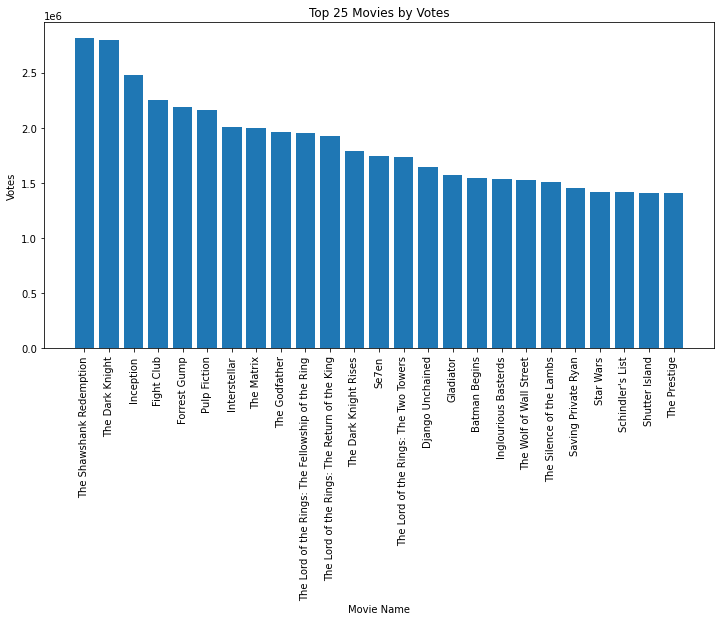

In [15]:
# Creating a bar chart for the top 25 movies
top_25_movies = df.sort_values(by='votes', ascending=False).head(25)
plt.figure(figsize=(12, 6))
plt.bar(top_25_movies['movie_name'], top_25_movies['votes'])
plt.title('Top 25 Movies by Votes')
plt.xlabel('Movie Name')
plt.ylabel('Votes')
plt.xticks(rotation=90)
plt.show()

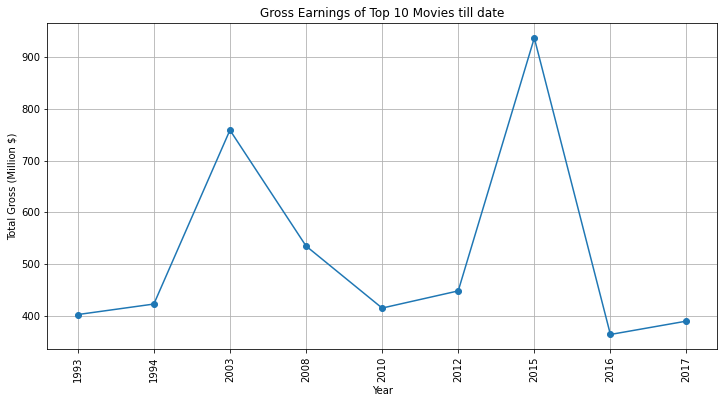

In [16]:
# Creating a bar chart for the top 25 movies by gross

data = pd.DataFrame({
    'Movie Name': df['movie_name'],
    'Year': df['year'],
    'Gross (Million $)': df['gross (Million $)']
})

# Sort the DataFrame by gross earnings in descending order
top_25_movies_gross = data.sort_values(by='Gross (Million $)', ascending=False).head(10)

# Group the data by year and calculate the total gross earnings for each year
yearly_gross = top_25_movies_gross.groupby('Year')['Gross (Million $)'].sum()

# Create a line chart
plt.figure(figsize=(12, 6))
yearly_gross.plot(marker='o', linestyle='-')
plt.title('Gross Earnings of Top 10 Movies till date')
plt.xlabel('Year')
plt.ylabel('Total Gross (Million $)')
plt.xticks(rotation=90)
plt.grid()
plt.show()


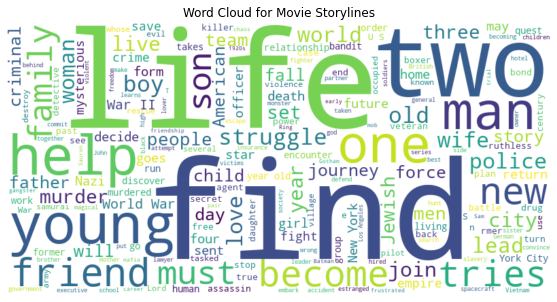

In [17]:
# Word Cloud chart created to identify the important words by reading the storyline of all the movies

text = ' '.join(df['storyline'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Movie Storylines')
plt.show()

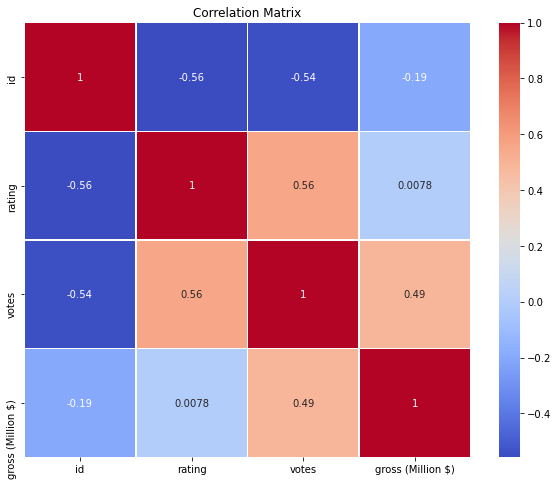

In [18]:
##to see the correlation among the numerical variables

# Calculating the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


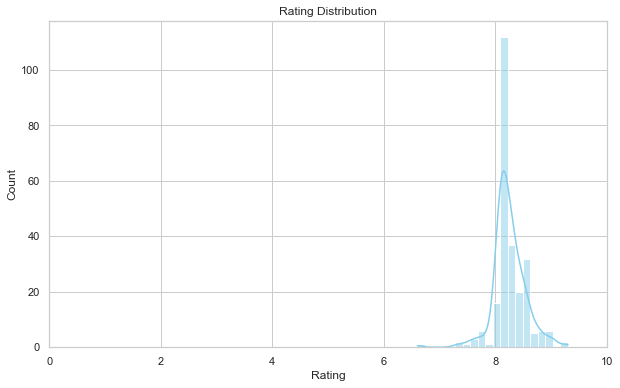

In [19]:
##Here we can see the distribution of ratings to understand how users rate the movies
#here the ratings skewed towards the positive end

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="rating", bins=20, kde=True, color='skyblue')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xlim(0, 10)

# Show the plot
plt.show()


Downloaded: movie_posters/The_Shawshank_Redemption_93.jpg


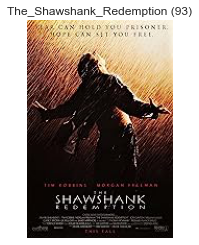

Downloaded: movie_posters/The_Godfather_92.jpg


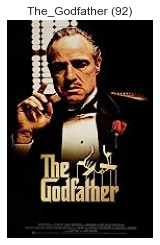

Downloaded: movie_posters/The_Dark_Knight_9.jpg


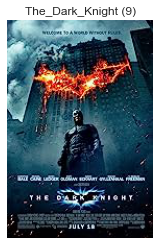

Downloaded: movie_posters/The_Godfather_Part_II_9.jpg


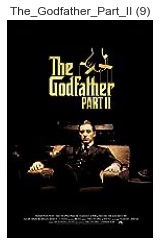

Downloaded: movie_posters/Pulp_Fiction_89.jpg


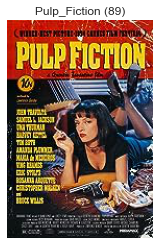

Downloaded: movie_posters/Schindlers_List_9.jpg


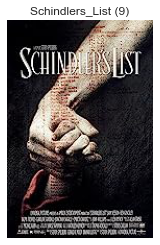

Downloaded: movie_posters/The_Lord_of_the_Rings_The_Return_of_the_King_9.jpg


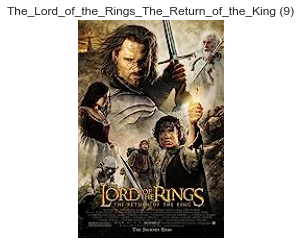

Downloaded: movie_posters/12_Angry_Men_9.jpg


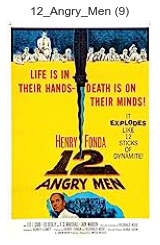

Downloaded: movie_posters/Il_buono_il_brutto_il_cattivo_88.jpg


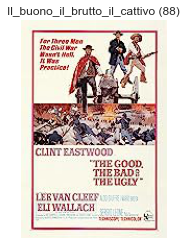

Downloaded: movie_posters/Forrest_Gump_88.jpg


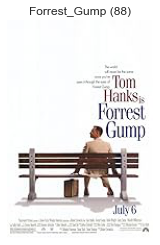

In [20]:
import requests
from bs4 import BeautifulSoup
import os
import re  # Import the regular expressions module
from PIL import Image
import matplotlib.pyplot as plt

# URL of the IMDb list
url = "https://www.imdb.com/list/ls068082370/"

# Send an HTTP GET request to the URL
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')

    # Finding the top 10 movies with the highest rating
    top_10_movies = soup.find_all('div', class_='lister-item mode-detail')[:10]

    # Creating a directory to store downloaded images
    if not os.path.exists('movie_posters'):
        os.mkdir('movie_posters')

    # Looping through the top 10 movies and download their posters
    for movie in top_10_movies:
        # Extracting the movie name and rating
        movie_name = movie.find('h3', class_='lister-item-header').a.text
        movie_rating = movie.find('span', class_='ipl-rating-star__rating').text

        # Clean up the movie name and rating to make them suitable for filenames
        movie_name = re.sub(r'[^\w\s]', '', movie_name)  # Remove special characters
        movie_name = re.sub(r'\s', '_', movie_name)  # Replace spaces with underscores
        movie_rating = re.sub(r'[^\w]', '', movie_rating)  # Remove non-alphanumeric characters

        # Finding and downloading the movie poster image
        poster_url = movie.find('div', class_='lister-item-image').img['loadlate']
        response = requests.get(poster_url)
        if response.status_code == 200:
            # Saving the image with the cleaned movie name and rating as the filename
            filename = f"movie_posters/{movie_name}_{movie_rating}.jpg"
            with open(filename, 'wb') as file:
                file.write(response.content)
            print(f"Downloaded: {filename}")

            # Displaying the downloaded poster image
            img = Image.open(filename)
            plt.imshow(img)
            plt.title(f"{movie_name} ({movie_rating})")
            plt.axis('off')
            plt.show()
        else:
            print(f"Failed to download image for {movie_name}")
else:
    print("Failed to retrieve the IMDb list")


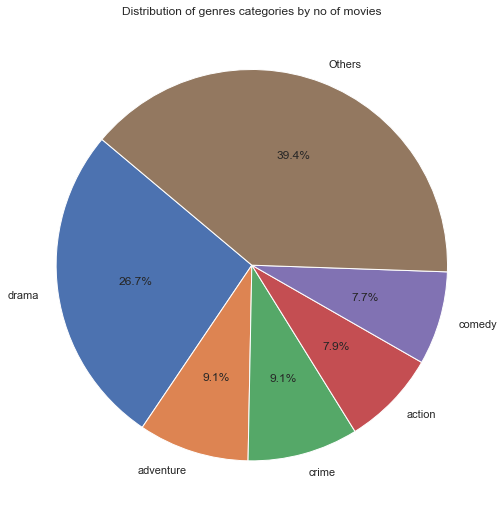

In [21]:
##creating pie chart of Distribution of genres categories by no of movies
data = pd.DataFrame({
    'Movie Name': df['movie_name'],
    'Movie Rating': df['rating'],
    'Genre': df['genre']
})

genre_data = data['Genre'].str.split(', ', expand=True).stack()
genre_data = genre_data.str.lower().str.strip()
genre_counts = genre_data.value_counts()
top_5_genres = genre_counts.head(5)
top_5_genres_df = top_5_genres.to_frame()
top_5_genres_df.loc['Others'] = genre_counts[5:].sum()
plt.figure(figsize=(9, 9))
plt.pie(top_5_genres_df[0], labels=top_5_genres_df.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of genres categories by no of movies')
plt.show()
